# Blood Fractionation Method Analysis

First, we configure several variables we are using during this demo: project id, S3 profile and VM path to save data files from the S3 bucket: 

In [5]:
from cdispyutils.hmac4 import get_auth
import requests, json, re
import pandas as pd

project = ''
profile = ''
path    = 'files/'

### Get Authorization using your keys from the BPA API: data.bloodpac.org/identity
These keys must be loaded in your VM's .secrets file. In the case of an access error, you may need a new keypair.

In [6]:
with open('/home/ubuntu/.secrets','r') as f:
    secrets = json.load(f)
auth = get_auth(secrets['access_key'], secrets['secret_key'], 'submission')


### Querying data from graphQL

** Find how many samples in commons have linked quantification assays:|**

In [7]:
# Setting 'gql' to the BloodPAC API graphQL url:
api='http://kubenode.internal.io:30006/v0/submission/bpa/'
gql = 'http://kubenode.internal.io:30006/v0/submission/graphql/'
data = {'query': """ {
            _sample_count(with_path_to:{type:"quantification_assay"})
        } """};

resp = requests.post(gql,auth=auth,json=data)
scount = re.search(".*_sample_count\": (\d+)",str(resp.text)).group(1)
print resp.text
scount


{
  "data": {
    "_sample_count": 392
  }
}


'392'

** Another way to do the same thing and get the samples' submitter_id and fractionation_method: **

In [14]:
 data = {'query': """ {
            sample(first:0,with_path_to:{type:"quantification_assay"}){
                submitter_id
                blood_fractionation_method
            }
        } """};

resp = requests.post(gql,auth=auth,json=data)
samps = re.findall(".*submitter_id\": \"(.+)\"",str(resp.text))
methods = re.findall('.*blood_fractionation_method\": \"(.+)\"',str(resp.text))
z = zip(samps,methods)
z = list(set(z))
len(z)

392

In [22]:
print "There are "+str(len(set(methods)))+" different blood fractionation methods for "+str(len(set(samps)))+" samples with links to quantification assays."

There are 3 different blood fractionation methods for 392 samples with links to quantification assays.


In [18]:
# List the Sample IDs and their blood fractionation method
zdf = pd.DataFrame(data=z)
zdf.columns = ['Sample ID', 'Blood Fractionation Method']
zdf 


,Sample ID,Blood Fractionation Method
0,08157,USC_HD-SCA_Protocol
1,09C23,USC_HD-SCA_Protocol
2,07830,USC_HD-SCA_Protocol
3,09BDD,USC_HD-SCA_Protocol
4,09C7C,USC_HD-SCA_Protocol
5,08311,USC_HD-SCA_Protocol
6,BPA_ES_P001_EX1_MG02-13-0021_TB8667_S,"Red blood cell lysis, nucleated cell centrifug..."
7,08074,USC_HD-SCA_Protocol
8,BPA_ES_P001_EX1_MG02-15-0013_TB12030_S,"Red blood cell lysis, nucleated cell centrifug..."
9,09910,USC_HD-SCA_Protocol


** Find the 'blood_fractionation_method" that yields the highest 'molecular_concentration':|**

** You will see that the following query in this cell returns: "Request Timeout" because it is returning too many results: **


In [69]:
data = {'query': """{
                        quantification_assay(first:0, 
                        not: {molecular_concentration:0}
                        order_by_desc:"molecular_concentration") {   
                               molecular_concentration
                               project_id
                               analytes(first:0){
                                   aliquots(first:0){
                                       samples(first:0){
                                           submitter_id
                                           blood_fractionation_method
                                       }
                                   }
                               }
                            }
                    } """};
resp = requests.post(gql, auth=auth, json=data)
print resp.text


{"error": {"Request Timeout"}}


** Using pagination with graphQL: **

We can use pagination (using combination of "offset" and "first") inside a loop to get all the data. 
When no data is returned, the API response is: `"quantification_assay": []`, which is when we break out of the loop.
When this string is matched, the length of r is "1" and our loops terminates. 
If any data is returned, there is no match, and len(r) is "0".

In [24]:
response = "" # this string will hold all the results
offset=0 # start at the first result, with no offset
r = () # r is a list that will contain the result of the regular expression that checks whether data is returned


while len(r) != 1:
    q = """{
                    quantification_assay(first:100,offset:"""+str(offset)+""", 
                    not: {molecular_concentration:0}
                    order_by_desc:"molecular_concentration"){
                        molecular_concentration
                        project_id
                        analytes(first:0){
                            aliquots(first:0){
                                samples(first:0){
                                    submitter_id
                                    blood_fractionation_method               
                                }
                            }
                        }
                    }
        } """
    data = {'query':q}
    resp = requests.post(gql, auth=auth, json=data)
    response += str(resp.text) # concatenate the returned data
    r = re.findall(".*quantification_assay\": \[\]",str(resp.text)) #this is where we check whether data was returned
    offset+=100 #increase the offset to get the next 100 records
    

** Using REGEX to extract our data from the response: **

In [31]:
methods = re.findall('.*blood_fractionation_method\": \"(.+)\"',response)
concs = re.findall(".*molecular_concentration\": (.+),",response)
c = map(float,concs)
ids = re.findall(".*submitter_id\": \"(.+)\"",response)
z = zip(methods,c)
assays = dict(zip(ids,z ))
#a = pd.DataFrame(data=assays)
a = pd.Series(assays, name='Method, Molecular Concentration')
a.index.name = 'Sample ID'
a.reset_index()

,Sample ID,"Method, Molecular Concentration"
0,07822,"(USC_HD-SCA_Protocol, 2.27295515364)"
1,07825,"(USC_HD-SCA_Protocol, 17.27268854)"
2,07829,"(USC_HD-SCA_Protocol, 5.75955880614)"
3,07830,"(USC_HD-SCA_Protocol, 39.0925406441)"
4,07849,"(USC_HD-SCA_Protocol, 3.83690169674)"
5,07859,"(USC_HD-SCA_Protocol, 1.25932711187)"
6,07910,"(USC_HD-SCA_Protocol, 5.73778531087)"
7,07915,"(USC_HD-SCA_Protocol, 0.799508302394)"
8,07933,"(USC_HD-SCA_Protocol, 3.96774528296)"
9,07981,"(USC_HD-SCA_Protocol, 1.12036640437)"


In [32]:
print("There are " + str(len(set(ids))) + " samples with " +
      str(len(set(methods))) + " different blood fractionation methods for " +
      str(len(concs)) + " different quantification assays with non-zero molecular concentrations.")

There are 314 samples with 1 different blood fractionation methods for 1203 different quantification assays with non-zero molecular concentrations.


### 2) Plot the distribution of molecular concentrations 

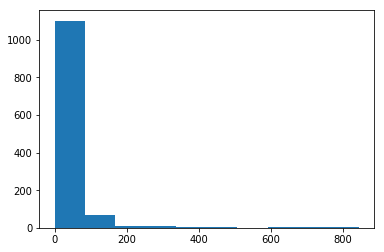

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

#plt.hist(numpy.log(c))
plt.hist(c)
plt.show()


In [75]:
print("mean: "+str(numpy.mean(c))+", median: "+str(numpy.median(c))+ ", max: "+str(max(c))+", min: "+str(min(c))+".")


mean: 28.1327587935, median: 5.85012616485, max: 844.907, min: 0.09.


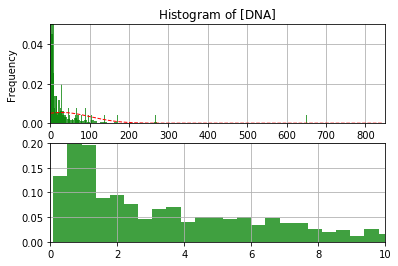

In [76]:
# the histogram of the data
plt.subplot(211)
n, bins, patches = plt.hist(c, 2000, normed=1, facecolor='green', alpha=0.75)
p = plt.hist(c, 100, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
mu = numpy.mean(c)
sigma = numpy.std(c)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('DNA Concentration')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ [DNA]}$')
plt.axis([0, 850, 0, 0.05])
plt.grid(True)


plt.subplot(212)
p = plt.hist(c, 2000, normed=1, facecolor='green', alpha=0.75)
plt.axis([0, 10, 0, 0.2])
plt.grid(True)

plt.show(p)


# Question: How many samples have blood_fractionation_method and molecular concentration?  Can you export a table with 2 columns for these two fields?


In [48]:
q = """{
  sample(first:0,
  with_path_to:[
  {type:"quantification_assay"},
  {type:"analyte",analyte_type:"DNA"}]) {
    blood_fractionation_method
    submitter_id
    project_id
    aliquots(first:0,with_path_to:[{type:"quantification_assay"},{type:"analyte",analyte_type:"DNA"}]) {
      analytes(first:0,analyte_type:"DNA") {
        quantification_assays(first:0) {
          molecular_concentration
        }
      }
    }
  } 
}"""



data = {'query':q}
resp = requests.post(gql, auth=auth, json=data)
jresp = json.loads(resp.text)
#jresp

In [49]:
mc = []
for i in jresp["data"]["sample"]:
    subid = i["submitter_id"]
    projid = i["project_id"]
    bfm = i["blood_fractionation_method"]
    dnac = []
    for j in i["aliquots"]:
        for k in j["analytes"]:
            for l in k["quantification_assays"]:
                dnac.append(l["molecular_concentration"])
    line = str(subid)+"\t"+str(projid)+"\t"+str(bfm)+"\t"+str(dnac)
#    print line
    mcs = [subid,projid,bfm,dnac]
    mc.append(mcs)    

In [50]:
print "There are "+str(len(mc))+" samples with 'blood_fractionation_method' and 'molecular concentration' and links to DNA analytes."

There are 138 samples with 'blood_fractionation_method' and 'molecular concentration'.


In [36]:
m = pd.DataFrame(data=mc)
m.columns = ['Sample ID', 'Project ID', 'Blood Fractionation Method', 'Molecular Concentration']
m

,Sample ID,Project ID,Blood Fractionation Method,Molecular Concentration
0,09A3B,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[14.6, 14.6, 14.6]"
1,09AAF,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.408]
2,09929,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[15.6, 15.6]"
3,09901,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.305]
4,09969,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.764]
5,09968,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.16]
6,09963,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.189]
7,09BB7,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.223]
8,09C02,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,[0.532]
9,09CE4,bpa-USC_OPT1_T1,USC_HD-SCA_Protocol,"[0.436, 0.436]"
